- Filename: `dissipation-theory--Study-29.ipynb`
- Continued from: `dissipation-theory--Study-28.ipynb`
- Continued to: ---

# Preliminaries

In [1]:
import numpy as np
import pandas

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import cycler

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 3.25, 3.5

In [3]:
THIS = 'dissipation-theory--Study-29--'
fig = {}

In [14]:
from dissipationtheory.constants import ureg, qe, epsilon0
from dissipationtheory.dissipation4 import CantileverModel, SampleModel1, SampleModel2
from dissipationtheory.dissipation4 import CantileverModelJit, SampleModel1Jit, SampleModel2Jit
from dissipationtheory.dissipation4 import theta1norm, gamma_perpendicular
from dissipationtheory.dissipation4 import theta1norm_jit, gamma_perpendicular_jit
from dissipationtheory.dissipation4 import blds_perpendicular, blds_perpendicular_jit
from dissipationtheory.dissipation4 import gamma_perpendicular_approx, BLDSzerohigh, BLDSzerolow, BLDSapproxK2

# Set up cantilever and sample

In [5]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(75, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(35, 'nm'), 
    d = ureg.Quantity(38, 'nm'),
    z_c = ureg.Quantity(73, 'nm')
)

In [6]:
cantilever.args()

{'f_c': 75000.0,
 'k_c': 2.8,
 'V_ts': 1,
 'R': 3.5e-08,
 'd': 3.8e-08,
 'z_c': 7.3e-08}

In [7]:
sample1 = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(500, 'nm'),
    epsilon_s = ureg.Quantity(complex(3, -0.2), ''),  # <== edit this
    sigma = ureg.Quantity(1E-5, 'S/m'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    z_r = ureg.Quantity(300, 'nm')
)

In [8]:
sample1.args()

{'cantilever': <numba.experimental.jitclass.boxing.CantileverModelJit at 0x12863ec70>,
 'h_s': 5.000000000000001e-07,
 'epsilon_s': (3-0.2j),
 'sigma': 1e-05,
 'rho': 1e+21,
 'epsilon_d': (1000000+0j),
 'z_r': 3.0000000000000004e-07}

In [9]:
sample1_jit = SampleModel1Jit(**sample1.args())
sample1_jit.print()

cantilever
        cantilever freq =  75000.0 Hz
                        =  471238.89803846896 rad/s
        spring constant =  2.8 N/m
     tip-sample voltage =  1.0 V
                 radius =  3.5e-08 m
                 height =  3.8e-08 m
  tip charge z location =  7.3e-08 m

semiconductor
          epsilon (real) =  3.0
          epsilon (imag) =  -0.2
               thickness =  5.000000000000001e-07 m
            conductivity =  1e-05 S/m
          charge density =  1e+21 m^{{-3}}
        reference height =  3.0000000000000004e-07 m
 
      roll-off frequency =  1129409.0673730192 Hz
                mobility =  6.241509090043337e-08 m^2/(V s)
      diffusion constant =  1.6135549206567651e-09 m^2/s
            Debye length =  3.7797775481848936e-08 m
        diffusion length =  5.851555252782804e-08 m
effective epsilon (real) =  3.0
effective epsilon (imag) =  -2.5966804779363124

dielectric
 epsilon (real) =  1000000.0
 epsilon (imag) =  0.0
      thickness = infinite


# Example friction calculation

Spot-check the new friction-calculation code by comparing a numba/jit result to a pure-Python result.

First, the numba/jit result.

In [10]:
%%time
ans1a = gamma_perpendicular_jit(theta1norm_jit, sample1_jit)
ans1a

CPU times: user 17.3 ms, sys: 2.89 ms, total: 20.2 ms
Wall time: 52.5 ms


Magnitude,[15.417929869393788 6.212249638646369 1.0688959054893934]
Units,piconewton second/meter


Now the pure Python result.

In [11]:
%%time
ans1b = gamma_perpendicular(theta1norm, sample1)
ans1b

CPU times: user 2.11 s, sys: 28.4 ms, total: 2.14 s
Wall time: 2.22 s


Magnitude,[15.417929869393793 6.212249638646362 1.0688959054893914]
Units,piconewton second/meter


By inspection we get the same result for the three terms' contribution to the friction.  Success!

The numba/jit calculation is 100 to 200 times faster.  

The friction is smaller here than in `Study 28` because the tip charge is further away now, located not at $d$ but at $z_\text{c} = d + R$.

# Example BLDS calculation

Compare the execution time for pure-Python and numba/jit calculations.

In [12]:
omega_m = ureg.Quantity(2 * np.pi * np.logspace(1, 2, 2), 'Hz')

In [15]:
%%time
ans2a = blds_perpendicular_jit(theta1norm_jit, sample1_jit, omega_m)
ans2a 

CPU times: user 29 ms, sys: 3.04 ms, total: 32 ms
Wall time: 35.3 ms


Magnitude,[[-0.4683740223649317 -0.14648217517320208 -0.4085176200827304] [-0.4683763355334917 -0.14648114836164003 -0.40841362543117204]]
Units,hertz


In [16]:
%%time
ans2b = blds_perpendicular(theta1norm, sample1, omega_m)
ans2b 

CPU times: user 7.2 s, sys: 108 ms, total: 7.31 s
Wall time: 8.59 s


Magnitude,[[-0.46837402236493186 -0.14648217517320197 -0.40851762008273074] [-0.468376335533492 -0.1464811483616399 -0.40841362543117243]]
Units,hertz


By inspection we get the same result for the two terms' contribution to the BDLS frequency shift. The numba/jit calculation is 150 to 200 times faster.

The BLDS frequency shift is smaller here than in `Study 28` because the tip charge is further away now, located not at $d$ but at $z_\text{c} = d + R$.

## Representative BLDS spectrum calculation

I am echoing the code from `Study 28` here.  Set up an array of modulation frequencies and an array of charge densities.

In [17]:
N_omega = 100
N_sigma = 50

In [18]:
omega_m = ureg.Quantity(
    np.logspace(
        start=np.log10(1e1),
        stop=np.log10(1e8),
        num=N_omega), 'Hz')

In [19]:
sigma = ureg.Quantity(
    np.logspace(
        start=np.log10(1e-9),
        stop=np.log10(1),
        num=N_sigma), 'S/m')

Assume a fixed mobility of $\mu = 10^{-8} \: \mathrm{m}^2/\mathrm{V s}$, an ionic mobility.  As we vary $\sigma$, we should vary the charge density $\rho$ to keep the mobility constant.

In [20]:
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
rho = (sigma / (qe * mu)).to('1/m^3')

Get ready to run the simulations.

In [21]:
data = {}        # many simulations
data['01'] = {}  # the first simulation

Loop over conductivities, computing the BLDS spectrum and the friction.

In [22]:
%%time

# remember
sigma0 = sample1_jit.sigma
rho0 =  sample1_jit.rho

# set
for rho_, sigma_ in zip(rho, sigma):

    sample1_jit.rho = rho_.to('1/m^3').magnitude
    sample1_jit.sigma = sigma_.to('S/m').magnitude

    gamma = gamma_perpendicular_jit(theta1norm_jit, sample1_jit).to('pN s/m')
    f_BLDS = blds_perpendicular_jit(theta1norm_jit, sample1_jit, omega_m).to('Hz')
    
    data['01'][str(sigma_.to('S/m').magnitude)] = {
        'omega_m': omega_m,
        'f_BLDS': f_BLDS, 
        'gamma': gamma,
        'sigma': ureg.Quantity(sample1_jit.sigma, 'S/m'),
        'd': ureg.Quantity(sample1_jit.cantilever.d, 'm'),
        'rho': ureg.Quantity(sample1_jit.rho, '1/m^3'),
        'LD': ureg.Quantity(sample1_jit.LD, 'm'),
        'omega_c': ureg.Quantity(sample1_jit.cantilever.omega_c, 'Hz'),
        'omega_0': (ureg.Quantity(sample1_jit.sigma, 'S/m')/epsilon0).to('Hz')}

# reset
sample1_jit.rho = rho0
sample1_jit.sigma = sigma0

CPU times: user 15.7 s, sys: 285 ms, total: 15.9 s
Wall time: 18.7 s


A helper plotting function.

In [25]:
def plotBLDS(data):

    rho = np.zeros(len(data))    
    for index, key in enumerate(data.keys()):
        
        rho[index] = data[key]['rho'].to('1/cm^3').magnitude

    # colormap = plt.cm.jet
    colormap = plt.cm.magma_r
    color_list = [colormap(i) for i in np.linspace(0, 1, len(data))]

    normalized_colors = mcolors.LogNorm(vmin=min(rho), vmax=max(rho))
    scalar_mappable = cm.ScalarMappable(norm=normalized_colors, cmap=colormap)
    scalar_mappable.set_array(len(color_list))
    
    fig, ax = plt.subplots(figsize=(4.5, 3))
    for index, key in enumerate(data.keys()):
        
        with plt.style.context('seaborn-v0_8'):
            plt.semilogx(
                data[key]['omega_m'].to('Hz').magnitude,
                np.abs(data[key]['f_BLDS'].sum(axis=1).to('Hz').magnitude),
                '-',
                color=color_list[index])

    # color bar
    clb=plt.colorbar(scalar_mappable, ax=ax)
    clb.ax.set_title(r'$\rho \: [\mathrm{cm}^{-3}]$', fontsize=12)
    
    plt.ylabel('|$\Delta f_{\mathrm{BLDS}}$| [Hz]')
    plt.xlabel('mod. freq. $\omega_{\mathrm{m}}$ [rad/s]')
    plt.tight_layout()
    plt.show()
    
    return fig

Plot every 3rd BLDS spectrum.

In [26]:
data['01-short'] = {}
for key in list(data['01'].keys())[::3]:
    data['01-short'][key] = data['01'][key]

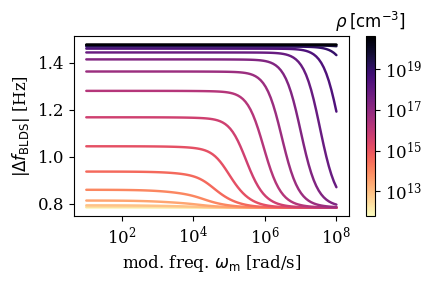

In [27]:
#| label: fig-blds
#| fig-cap: "Broadband local dielectric spectrum of a semi-infinite semiconductor versus charge density."

fig['01'] = plotBLDS(data['01-short'])

Convert the data dictionary to a pandas dataframe.  We want to exract the data in the rows, as numbers without units, for plotting.  Loop over each row in the dataframe, converting each row to a numpy array.  For each row, loop over the elements of the array, specify the element's units, and get the magnitude of the resulting element.  Convert the result list to a numpy array. 

In [34]:
def plotme(data, sample):

    df = pandas.DataFrame.from_dict(data)

    keys =  ['omega_m', 'f_BLDS', 'gamma',  'sigma', 'd', 'rho',   'LD', 'omega_c', 'omega_0']
    units = ['Hz',      'Hz',     'pN s/m', 'S/m',   'm', '1/m^3', 'm',  'Hz',      'Hz']

    adict = {}
    for key, unit in zip(keys, units):
        adict[key] = np.array([a.to(unit).magnitude for a in df.loc[key].to_numpy()])

    # (Left hand plot) 
    # Make the x-axis the unitless ratio of the height to Debye length squared,
    # which is proportional to charge density.

    xL = (adict['d']/adict['LD'])**2
    rho0L = (adict['rho']/xL)[0]
    
    # Define functions to convert from xL to rho and back again
    
    def fwdL(xL):
        return xL*rho0L

    def revL(rho):
        return rho/rho0L

    # (Right hand plot)
    # Make the x-axis the unitless ratio of omega_0 to omega_c, which
    # is proportional to conductivity and therefore charge density

    xR = adict['omega_0']/(sample.epsilon_s.real.magnitude * adict['omega_c'])
    rho0R = (adict['rho']/xR)[0]
    
    # Define functions to convert from xR to rho and back again

    def fwdR(xR):
        return xR*rho0R

    def revR(rho):
        return rho/rho0R
    
    # Now make the nice plot
    
    fig, ax = plt.subplots(1, 2, figsize=(7.5, 5))
    
    ax2L = ax[0].secondary_xaxis("top", functions=(fwdL,revL))
    ax2R = ax[1].secondary_xaxis("top", functions=(fwdR,revR))

    # xL_sub, BLDS_sub = BLDSapprox(sample, xL)
    
    with plt.style.context('seaborn-v0_8'):

        # get current color cycle
        
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        color_cycle = cycler.cycler('color', colors[0:3])
        ax[0].set_prop_cycle(color_cycle)
        ax[1].set_prop_cycle(color_cycle)
        
        # approximation for zero-freq BLDS, K2 term
        
        x_sub, BLDSapprox = BLDSapproxK2(sample1, xL)
        ax[0].semilogx(
            x_sub,
            BLDSapprox,
            ':',
            color=colors[0],
            label=['$K_2$ approx.'])

        # exact calculations
        
        ax[0].semilogx(
            xL,
            adict['f_BLDS'][:,0,:], 
            '-',
            label=['$K_2$','$K_1$','$K_0$'])
        
        ax[1].loglog(
            xR,
            adict['gamma'], 
            '-',
            label=['$K_2$','$K_1$','$K_0$'])
        
        # limiting cases
        
        nL_part = int(2*len(xL)/3)
        
        ax[0].semilogx(
            xL[0:nL_part],
            BLDSzerolow(sample1, xL)[0:nL_part,:], 
            '--')
        
        ax[0].semilogx(
            xL[-nL_part:-1],
            BLDSzerohigh(sample1, xL)[-nL_part:-1,:],
            '-.')

        nR_part = int(len(xR)/2)

        g_low, g_approx = gamma_perpendicular_approx(sample1, xR)

        ax[1].loglog(
            xR[0:nR_part],
            g_low[0:nR_part,:],
            '--')
        
        ax[1].loglog(
            xR[0:nR_part],
            g_approx[0:nR_part,:],
            ':',
            label=['$K_2$ approx','$K_1$ approx','$K_0$ approx'])

    ax[0].set_xlabel(r'$(h / \lambda_{\mathrm{D}})^2$')
    ax[0].set_ylabel(r'$\Delta f_{\mathrm{BLDS}}(\omega_{\mathrm{m}}=0)$ [Hz]')
    ax[0].legend(fontsize=9)
    ax[0].grid()
    ax[1].grid()
    
    ax[1].set_xlabel(r'$\omega_0/(\epsilon_{\mathrm{s}}^{\prime} \omega_{\mathrm{c}})$')
    ax[1].set_ylabel(r'$\gamma_{\perp}$ [pN s/m]')
    ax[1].legend(fontsize=9)
    ax[1].set_ylim(
        [0.95 * adict['gamma'].min(),
         1.05 * adict['gamma'].max()])
    
    ax2L.set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    ax2R.set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    
    plt.tight_layout()
    plt.show()
    
    return fig

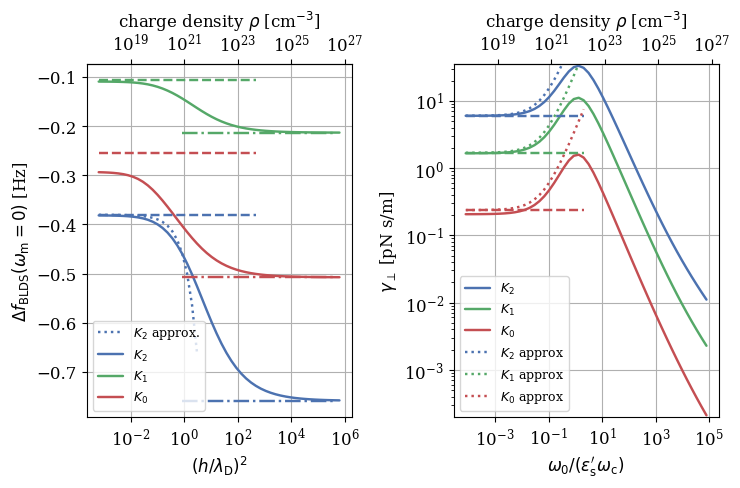

In [35]:
fig['02'] = plotme(data['01'], sample1)

Compared to `Study 28`, the BLDS frequency shift is smaller here by a factor of approximately 8 smaller.  This is a significant change.

# Save all figures

In [36]:
if 1:
    for num in fig.keys():
        figname = THIS + "Fig-" + num
        fig[num].savefig(figname + '.png', dpi=300)
        fig[num].savefig(figname + '.pdf')